# 1.提取公司年报信息：呈现基础数据表&最近三年基本每股收益表

In [1]:
from IPython.display import display, HTML

In [5]:
# encoding:utf8

import os
import time
import pdfplumber
import re
from IPython.display import display, HTML
from pandas import DataFrame

pdf_path = "2019"
text_path = "2019_text"

if not os.path.exists(pdf_path):
    os.mkdir(pdf_path)
if not os.path.exists(text_path):
    os.mkdir(text_path)

flags = {
    "info": {
        "big": {"start": "一、公司信息", "end": "二、联系人和联系方式"},
        "small": {}
    },
    "income": {
        "big": {"start": "五、主要会计数据和财务指标", "end": "六、分季度主要财务指标"},
        "small": {}
    }
}
info_key_list = [
    "股票简称",
    "股票代码",
    "公司的法定代表人",
    "办公地址",
    "公司国际互联网网址",
    "电子信箱"
]


def change_form(unchange_list):
    for i in unchange_list:
        print("正在转换{}文件为txt格式......".format(i))
        with pdfplumber.open("{}/{}.pdf".format(pdf_path, i)) as pdf:
            with open("{}/{}.txt".format(text_path, i), "w", encoding="utf8") as f:
                for page in pdf.pages:
                    if page.extract_text() != None:
                        f.write(page.extract_text())
                    else:
                        f.write("\n")


def check_file_list():
    pdf_list = os.listdir(pdf_path)
    pdf_file_name_list = [i.rstrip(".pdf") for i in pdf_list]
    text_list = os.listdir(text_path)
    text_file_name_list = [i.rstrip("txt") for i in text_list]
    unchange_list = list(set(pdf_file_name_list).difference(set(text_file_name_list)))
    return unchange_list


def get_flag_data(flag, text):
    start_index = text.find(flags[flag]['big']['start'])
    end_index = text.find(flags[flag]['big']['end'])
    result_part = text[start_index:end_index]
    return result_part


def get_data(text_list):
    result_dict = {}
    for i in text_list:
        text = open("{}/{}".format(text_path, i), "r", encoding="utf8").read()
        info_part = get_flag_data("info", text)
        income_part = get_flag_data("income", text)
        result_dict[i] = {
            "info_part": info_part,
            "income_part": income_part
        }
    return result_dict


def info_change_to_dict(info_text):
    info_list = re.split(" \n|\n", info_text)
    temp_dict = {key: "" for key in info_key_list}
    for i in info_list:
        for j in info_key_list:
            i_list = i.split(" ")
            i_list=[m.strip() for m in i_list]
            if j in i_list:
                if j.strip()=="股票简称"or j.strip()=="股票代码":
                    for k in i_list:
                        if k==j:
                            # print(i_list[i_list.index(j)+1:])
                            for l in i_list[i_list.index(j)+1:]:
                                if l!="":
                                    temp_dict[j]=l
                                    break
                                else:
                                    continue
                else:
                    i_list.remove(j)
                    temp_dict[j] = " ".join(i_list)
    return temp_dict


def data_change_to_dict(data_text):
    data_list = data_text.split("\n")
    temp_dict = {"2019": "", "2018": "", "2017": ""}
    for i in data_list:
        i_list = i.split(" ")
        if "基本每股收益（元/股）" in i_list:
            new_i_list = [j for j in i_list if j != "" and j != "基本每股收益（元/股）" and "%" not in j]
            if len(new_i_list) == 3:
                temp_dict["2019"] = new_i_list[0]
                temp_dict["2018"] = new_i_list[1]
                temp_dict["2017"] = new_i_list[2]
                return temp_dict
            elif len(new_i_list) == 5:
                temp_dict["2019"] = new_i_list[0]
                temp_dict["2018"] = new_i_list[2]
                temp_dict["2017"] = new_i_list[4]
                return temp_dict
            else:
                return None
    else:
        return None


if __name__ == "__main__":
    '''
    1.循环检查所有pdf，如果有pdf没有转换成txt，进行转换 ok
    2.循环所有txt                                     
    3.提取所有txt需要的内容
    4.循环输出
    '''

    start_time = time.time()
    result_list = []
    check_result = check_file_list()
    if check_result != []:
        change_form(check_result)
    new_text_list = os.listdir(text_path)
    middle_data = get_data(new_text_list)
    result_info_dict = {i: [] for i in info_key_list}
    result_data_dict = {"公司名称":[],"2019年基本每股收益（元/股）": [], "2018年基本每股收益（元/股）": [], "2017年基本每股收益（元/股）": [], }
    for file_name in middle_data:
        info = middle_data[file_name]['info_part']
        info_dict = info_change_to_dict(info)
        data = middle_data[file_name]['income_part']
        data_dict = data_change_to_dict(data)
        if data_dict != None:
            for i in info_dict:
                result_info_dict[i].append(info_dict[i])
            result_data_dict["公司名称"].append(info_dict["股票简称"])
            result_data_dict["2019年基本每股收益（元/股）"].append(data_dict["2019"])
            result_data_dict["2018年基本每股收益（元/股）"].append(data_dict["2018"])
            result_data_dict["2017年基本每股收益（元/股）"].append(data_dict["2017"])
    df1 = DataFrame(result_info_dict)
    df2 = DataFrame(result_data_dict)
    print("公司信息：")
    display(df1)
    print("基本每股收益情况：")
    display(df2)


公司信息：


股票简称    股票代码        公司的法定代表人                                        办公地址  \
0   恒信东方  300081             孟宪民                       北京市海淀区蓝靛厂南路牛顿办公区北区11层   
1   华中数控  300161             陈吉红                               武汉市东湖开发区华工科技园   
2   元力股份  300174             许文显          福建省南平市陈坑至瓦口工业园区  办公地址的邮政编码  353013   
3   日科化学  300214             彭国锋                              山东省昌乐县英轩街3999号   
4   方直科技  300235             黄元忠                       深圳市南山区大新路198号创新大厦B座9楼   
5   华录百纳  300291              方刚                           北京市朝阳区安家楼50号院A7-2   
6   晶盛机电  300316             曹建伟                        浙江省杭州市余杭区五常街道创智一号2号楼   
7   博腾股份  300363             居年丰    重庆市北碚区水土园区方正大道重庆博腾制药科技股份有限公司新药外包服务基地研发中心   
8   安控科技  300370             许永良                             北京市海淀区地锦路9号院6号楼   
9   四通新材  300428             臧立国                              保定市清苑区发展西街359号   
10   普丽盛  300442             姜卫东                            上海市金山区张堰镇金张支路84号   
11  创业慧康  300451              葛航                    杭州市滨江区长河街道越达巷92号创业智慧大厦五楼   
12  惠伦晶体  300460             赵积清                           广东省东莞市黄江镇黄江东环路68号   
13  山鼎设计  300492              陈栗                      成都市锦江区东大街芷泉段6号1栋1单元37层   
14   新易盛  300502             高光荣                           成都市双流区公兴镇物联西街127号   
15  天邑股份  300504             李世宏                         四川省大邑县晋原镇雪山大道一段198号   
16   川金诺  300505              刘甍                        云南省昆明市呈贡区上海东盟大厦A座10楼   
17  新光药业  300519             王岳钧                           浙江省嵊州市剡湖街道环城西路25号   
18  幸福蓝海  300528             蒋小平                              南京市栖霞区元化路8号28幢   
19  同益股份  300538             邵羽南   广东省深圳市宝安区新安街道海旺社区N12区新湖路99号壹方中心北区三期A塔1001   
20  川环科技  300547             文谟统                               四川省达州市大竹县工业园区   
21  博创科技  300548     ZHU WEI(朱伟)                            浙江省嘉兴市南湖区亚太路306号   
22   万里马  300591             林大耀                 广州市海珠区新港东路1028号保利世界贸易中心F座3层   
23  宣亚国际  300612              邬涛                         北京市朝阳区八里庄东里1号CN02-B   
24  博士眼镜  300622   ALEXANDER LIU            深圳市罗湖区深南东路5016号京基一百大厦A座2201-02单元   
25  扬帆新材  300637              樊彬                       浙江省杭州市滨江区信诚路31号扬帆大厦五楼   
26  圣邦股份  300661             张世龙                     北京市海淀区西三环北路87号13层3-1301   
27  大烨智能  300670              陈杰                              南京市江宁区将军大道223号   
28  富满电子  300671             刘景裕                   深圳市福田区香蜜湖街道农园路时代科技大厦西区18楼   
29  中科信息  300678             史志明                              四川省成都市人民南路四段9号   
30   一品红  300723             李捍雄                广州市天河区珠江新城金穗路星汇国际大厦西塔17层01单元   
31  华致酒行  300755             彭宇清                    北京市东城区白桥大街15号嘉禾国信大厦CD座5层   
32  新媒股份  300770             林瑞军                          广州市人民北路686号自编25幢后座   
33  三角防务  300775             严建亚                               西安市航空基地蓝天二路8号   
34  惠城环保  300779             张新功                           青岛经济技术开发区淮河东路 57号   
35  唐源电气  300789              周艳                    成都市武侯区武兴五路355号西部智谷A1-1-9   
36  壹网壹创  300792             林振宇         浙江省杭州市经济技术开发区白杨街道科技园路2号2幢14层01-14单元   
37  久量股份  300808             卓楚光                         广州市白云区云城西路白云绿地中心27楼   

                                           公司国际互联网网址  \
0                              http://www.hxgro.com/   
1                                www.huazhongcnc.com   
2    www.yuanlicarbon.com  电子信箱  dm@yuanlicarbon.com   
3                            http://www.rikechem.com   
4                                 www.kingsunedu.com   
5                                http://www.hlbn.cc/   
6                                http://www.jsjd.cc/   
7                               http://www.porton.cn   
8                                      www.etrol.com   
9                             http://www.stnm.com.cn   
10                                    www.cn-pls.com   
11                         https://www.bsoft.com.cn/   
12                             http://www.dgylec.com   
13                       http://www.cendes-arch.com/   
14                                 www.eopt

基本每股收益情况：


公司名称 2019年基本每股收益（元/股） 2018年基本每股收益（元/股） 2017年基本每股收益（元/股）
0   恒信东方           0.1068           0.3739           0.1889
1   华中数控           0.0887           0.0966           0.1902
2   元力股份           0.2187           0.3376           0.1988
3   日科化学             0.42             0.24             0.23
4   方直科技             0.19             0.07             0.05
5   华录百纳           0.1401          -4.2063           0.1356
6   晶盛机电             0.50             0.46             0.30
7   博腾股份             0.35             0.26             0.25
8   安控科技           0.0136          -0.5748           0.1108
9   四通新材             0.77             0.75             0.78
10   普丽盛             0.13            -2.41             0.09
11  创业慧康             0.43             0.30             0.23
12  惠伦晶体          -0.7901          -0.1325             0.14
13  山鼎设计             0.26             0.32             0.25
14   新易盛           0.9059           0.1366           0.4772
15  天邑股份             0.40             0.61            1.150
16   川金诺           0.7330           0.6866           0.6489
17  新光药业             0.59             0.55             0.66
18  幸福蓝海             0.02            -1.43             0.30
19  同益股份             0.26             0.20             0.12
20  川环科技           0.6430           1.1414           0.9558
21  博创科技             0.09             0.03             0.97
22   万里马           0.0769           0.1211             0.14
23  宣亚国际             0.07             0.13             0.48
24  博士眼镜             0.52             0.69             0.65
25  扬帆新材             0.44             0.60             0.30
26  圣邦股份           1.7022           1.0059           0.9769
27  大烨智能           0.1158           0.1227           0.2152
28  富满电子             0.26             0.38             0.47
29  中科信息           0.1960           0.2600           0.2767
30   一品红             0.89             1.29             1.27
31  华致酒行             0.78             1.29             1.17
32  新媒股份             3.36             2.13             1.14
33  三角防务             0.40             0.34             0.27
34  惠城环保             0.48             0.85             0.67
35  唐源电气           2.1775           2.4243            1.790
36  壹网壹创             3.37             2.71              2.3
37  久量股份             0.64             0.74             0.53

# 2.画图实验

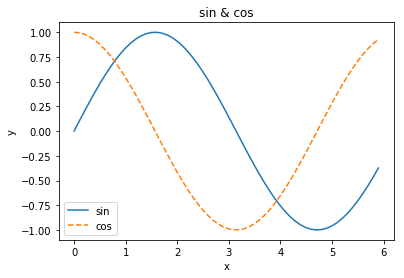

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, 6, 0.1)
y1 = np.sin(x)
y2 = np.cos(x)
plt.plot(x,y1,label="sin")
plt.plot(x,y2,label="cos",linestyle = "--")
plt.xlabel("x")
plt.ylabel("y")
plt.title('sin & cos')
plt.legend()   
plt.show()

## 图表解释如下：

图中展现的是正弦函数与余弦函数的图像

### （1）正弦函数 $$\sin x$$

1）性质：


①周期性：最小正周期都是2π


②奇偶性：奇函数


③对称性：对称中心是(Kπ,0)，K∈Z；对称轴是直线x=Kπ+π/2，K∈Z


④单调性：在[2Kπ-π/2,2Kπ+π/2]，K∈Z上单调递增；在[2Kπ+π/2,2Kπ+3π/2]，K∈Z上单调递减


2）定义域：R


3）值域：[-1,1]


4）最值：当X=2Kπ (K∈Z)时，Y取最大值1；当X=2Kπ +3π /2(K∈Z时，Y取最小值－1

### （2）余弦函数 $$\cos x$$

1）性质：


①周期性：最小正周期都是2π


②奇偶性：偶函数


③对称性：对称中心是(Kπ+π/2,0)，K∈Z；对称轴是直线x=Kπ，K∈Z


④单调性：在[2Kπ,2Kπ+π]，K∈Z上单调递减；在[2Kπ+π,2Kπ+2π]，K∈Z上单调递增


2）定义域：R


3）值域：[-1，1]


4）最值：当X=2Kπ +π /2(K∈Z)时，Y取最大值1；当X=2Kπ +π (K∈Z时，Y取最小值－1